# Data preparation



In [1]:
# to view longer dfs I set print option
options(dplyr.print_max = 1e9)
library(microbiome)
library(tidyverse)
library(here)
# load HITChip data using Leo's script
source(here("R/read.R"))

Loading required package: phyloseq
Loading required package: ggplot2

microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2018 Leo Lahti et al. <microbiome.github.io>


Attaching package: ‘microbiome’

The following object is masked from ‘package:base’:

    transform

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.0.1     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.3.1     ✔ stringr 1.3.1
✔ tibble  2.0.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo
Loading required package: DBI
Loading required package: preprocessCore
Loading required package: RMySQL
Loading required package: RPA
Loading required package: affy
Loading required package: BiocGenerics
Loading requ

In [2]:
div <- diversities(genus, index = "all") %>% rownames_to_column("sample")
div %>% head()


sample,inverse_simpson,gini_simpson,shannon,fisher,coverage
sa_2288,13.136503,0.9238762,3.287956,5.184989,7
sa_3262,3.058327,0.6730239,1.852293,5.253170,2
sa_1746,25.006936,0.9600111,3.662045,5.342255,9
sa_7099,2.627252,0.6193742,1.879375,5.233835,1
sa_9870,2.697641,0.6293058,1.622226,5.149014,1
sa_10996,2.767507,0.6386639,1.986984,5.335409,1


In [3]:
# load sample_data. disregard duplicate samples: %>% distinct(My.SQL.ID, .keep_all = TRUE)
# seems like this metadata is not complete. Therefore I use the excel from Gerben metadata <- sample_data(genus)
# colnames(metadata)
metadata <- readxl::read_excel(here("data/meta_data/my.metadata.xlsx"))
# to select the correct infants I use the resulting dataframe that arised from Gerbens selection process
select_samples <- read_csv(here("data/csv_gerben/complete.csv"))
# to confirm we have 49 pre/post for both groups
select_samples %>% group_by(childcarecenter, groupcode) %>% summarise(n = n())
# rename and disregard samples unrelated to the cc project
metadata <- metadata %>%
    rename(subject_id = subject, sample = "Var.2") %>%
    filter(sample %in% select_samples$sample)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  Group = col_character(),
  groupcode = col_character()
)
See spec(...) for full column specifications.


childcarecenter,groupcode,n
1,KDV1,49
1,KDV5,49
2,KDV1,49
2,KDV5,49


In [4]:
# we have additional information stored in another excel sheet:
# I need to control for the age at CC entrace and the total length of CC (unless CC will extend)
# beyond post, which is just the indicator of the stool sample closest to post
# same for breastfeeding: I need the number or %BF until entrance and then during entrance,
# where % means breasfeedings/(breasfeedings + formula feedings), because those two variables will
# be highly correlated I assume, but I can check that...
# so the questions I need to aks are: have their been children who remained in CC after they gave their second sample?
# I assume that age at sample is in fact not the same among infants? (then 75, 105 etc. should be renamed really)
metadata2 <- readxl::read_excel(here("data/meta_data/my.metadata2.xlsx"), sheet = "Data")
metadata2 <-
    metadata2 %>%
            filter(ID %in% metadata$subject_id) %>%
            rename(
                subject_id = ID,
                cc = Childcare_yesno,
                per_bf_during_cc = `%BEFbetweenKDV1andKDV2`,
                bf_until_end_cc = WeeksBEF,
                age_startcc_w = Begin_age_weeks, 
                age_pre_d = ExactageCCmin2d, 
                age_post_d = ExactageCCplus28) %>%
            mutate(
                age_pre_d = ifelse(is.na(age_pre_d), age_startcc_w * 7 -2, age_pre_d),
                age_post_d = ifelse(is.na(age_post_d), Age_plus4weeks * 7, age_post_d), 
                age_pre_w = age_pre_d/7, 
                age_post_w = age_post_d/7, 
                weeks_cc = (age_post_d - age_pre_d +2)/7)

In [5]:
# how much variation is there in the # of week subjects were in CC between pre and post?
metadata2 %>% summarise(mean_weeks_cc = mean(weeks_cc), sd_weeks_cc = sd(weeks_cc))

mean_weeks_cc,sd_weeks_cc
4.599155,0.229898


In [6]:
# merge metadata, rename time (because it does not correspond to real age)
meta <- metadata %>%
    left_join(metadata2, by = "subject_id") %>%
    mutate(time = ifelse(time == "75", "pre", "post")) %>%
    select(subject_id, time, cc, age_pre_d, age_post_d, age_startcc_w, weeks_cc, bf_until_end_cc, per_bf_during_cc, sample)

In [7]:
meta %>% head()

subject_id,time,cc,age_pre_d,age_post_d,age_startcc_w,weeks_cc,bf_until_end_cc,per_bf_during_cc,sample
202,pre,1,75,105,11.00,4.571429,15,100,sa_11183
202,post,1,75,105,11.00,4.571429,15,100,sa_5986
204,pre,0,72,99,10.57,4.142857,3,0,sa_11180
204,post,0,72,99,10.57,4.142857,3,0,sa_7451
207,pre,0,68,98,10.00,4.571429,14,100,sa_832
207,post,0,68,98,10.00,4.571429,14,100,sa_10000


In [8]:
# Next we need to load additional metadata about the number of week breastfeeding and formula feeding
# as can be looked up in R/read_metadata_long.R, we get a df called meta_long
# ok I see a problem: above we have bf_before_cc, which is just +1 for each week an infant had bf, thereby
# disregarding the amount of bf. See example for changing average feedings in printed df
source(here("R/read_metadata_long.R"))

In [9]:
# After I had a look at the data above, I now try to replicate the bf_weeks and then change it to a count bf_before_cc
# and a count bf_weeks_cc
meta_long <-
    meta_long %>%
        rename(subject_id = subject) %>%
        filter(subject_id %in% meta$subject_id) %>%
        left_join(meta, by = "subject_id")

In [10]:
# intialize columns
meta$bf_count_pre <- NA
meta$bf_count_post <- NA
meta$bf_count_cc <- NA
meta$formula_count_pre <- NA
meta$formula_count_post <- NA
meta$formula_count_cc <- NA

# select only variables needed. I checked all the infants with NA for bf, formula and exp.bf
# most of the time there is NA for bf if e.g subject was formula fed with high count or vice versa
# if not then these are only a few rows and given the consistency, most reasonably is to insert the value
# that was given before. The infant cannot starve + it received the same number of feedings before.
# only subjects 252, 448 have critically many NA. We would need to impute or drop those 2. They are both cc

# if there is NA but there is info in the other feedings columns, then NA = 0,
# else most likely NA = mean(averge_before) unless subjects are 252 and 448 (why? because mothers throughout the
# whole data are very consistent in feedings behavior and the did not starve the infant for 1-2 days. So, here 
# I make an assumption for these rows. 
bf_imputed <-
    meta_long %>%
        select(subject_id, bf, expressed_bf, formula, week, age_pre_d, age_post_d, age_startcc_w, weeks_cc) %>%
        filter(!subject_id %in% c(252, 448)) %>%
        mutate(
            bf = ifelse(is.na(bf)&(!is.na(expressed_bf)|!is.na(formula)), 0,
                ifelse(is.na(bf)&is.na(expressed_bf)&is.na(formula), mean(bf, na.rm = T), bf))) %>%
        select(subject_id, week, age_pre_d, age_post_d, age_startcc_w, weeks_cc, bf)
#
expressed_bf_imputed <-
    meta_long %>%
        select(subject_id, bf, expressed_bf, formula) %>%
        filter(!subject_id %in% c(252, 448)) %>%
        mutate(
            expressed_bf = ifelse(is.na(expressed_bf)&(!is.na(bf)|!is.na(formula)), 0,
                ifelse(is.na(bf)&is.na(expressed_bf)&is.na(formula), mean(expressed_bf, na.rm = T), expressed_bf))) %>%
        select(expressed_bf)

#
formula_imputed <-
    meta_long %>%
        select(subject_id, bf, expressed_bf, formula) %>%
        filter(!subject_id %in% c(252, 448)) %>%
        mutate(
            formula = ifelse(is.na(formula)&(!is.na(bf)|!is.na(expressed_bf)), 0,
                ifelse(is.na(bf)&is.na(expressed_bf)&is.na(formula), mean(formula, na.rm = T), formula))) %>%
        select(formula)
feeding_imputed <- bind_cols(bf_imputed, expressed_bf_imputed, formula_imputed)
# add expressed bf and bf together because for our research question it does not matter
feeding_imputed <- feeding_imputed %>% mutate(bf = bf + expressed_bf)

In [11]:
feeding_imputed %>% 
    mutate(
        prea = age_pre_d/7, 
        preb = round(age_pre_d/7), 
        posta = age_post_d/7, 
        postb = round(age_post_d/7), 
        diff = posta - prea, 
        diff_r = round(diff), 
        diff_r2 = round(postb - preb)) %>%
    select(subject_id, prea, preb, posta, postb, diff, diff_r, diff_r2, weeks_cc) %>% 
    distinct(subject_id, .keep_all = T)

subject_id,prea,preb,posta,postb,diff,diff_r,diff_r2,weeks_cc
202,10.714286,11,15.00000,15,4.285714,4,4,4.571429
204,10.285714,10,14.14286,14,3.857143,4,4,4.142857
207,9.714286,10,14.00000,14,4.285714,4,4,4.571429
210,15.857143,16,20.14286,20,4.285714,4,4,4.571429
211,10.142857,10,14.42857,14,4.285714,4,4,4.571429
213,12.571429,13,16.85714,17,4.285714,4,4,4.571429
216,9.714286,10,14.28571,14,4.571429,5,4,4.857143
228,10.714286,11,15.14286,15,4.428571,4,4,4.714286
233,10.428571,10,14.57143,15,4.142857,4,5,4.428571
234,10.000000,10,14.28571,14,4.285714,4,4,4.571429


In [12]:
# now for each subject and feedintype I need to aggregate the feedings
# I divide the sum by two because each week is in the two times 
for (id in unique(feeding_imputed$subject_id)) {
    # pre CC bf
    bf_count_pre <-
        feeding_imputed %>% filter(subject_id == id, week < round(age_pre_d/7)) %>%
        select(bf) %>%
            sum()/2
    meta[meta$subject_id == id, "bf_count_pre"] = bf_count_pre
    # post CC bf
    bf_count_post <-
        feeding_imputed %>% filter(subject_id == id, week < round(age_post_d/7)) %>%
        select(bf) %>%
            sum()/2
    meta[meta$subject_id == id, "bf_count_post"] = bf_count_post
    # during CC bf
    meta[meta$subject_id == id, "bf_count_cc"] = bf_count_post - bf_count_pre

    # pre CC formula
    formula_count_pre <-
        feeding_imputed %>% filter(subject_id == id, week <= round(age_pre_d/7)) %>%
        select(formula) %>%
            sum()/2
    meta[meta$subject_id == id, "formula_count_pre"] = formula_count_pre
    # post CC formula
    formula_count_post <-
        feeding_imputed %>% filter(subject_id == id, week <= round(age_post_d/7)) %>%
        select(formula) %>%
            sum()/2
    meta[meta$subject_id == id, "formula_count_post"] = formula_count_post
    # during CC formula
    meta[meta$subject_id == id, "formula_count_cc"] = formula_count_post - formula_count_pre
}

In [13]:
meta %>% head()

subject_id,time,cc,age_pre_d,age_post_d,age_startcc_w,weeks_cc,bf_until_end_cc,per_bf_during_cc,sample,bf_count_pre,bf_count_post,bf_count_cc,formula_count_pre,formula_count_post,formula_count_cc
202,pre,1,75,105,11.00,4.571429,15,100,sa_11183,74.5,105.5,31,0,1,1
202,post,1,75,105,11.00,4.571429,15,100,sa_5986,74.5,105.5,31,0,1,1
204,pre,0,72,99,10.57,4.142857,3,0,sa_11180,22.5,22.5,0,44,64,20
204,post,0,72,99,10.57,4.142857,3,0,sa_7451,22.5,22.5,0,44,64,20
207,pre,0,68,98,10.00,4.571429,14,100,sa_832,78.0,102.0,24,0,0,0
207,post,0,68,98,10.00,4.571429,14,100,sa_10000,78.0,102.0,24,0,0,0


In [14]:
# those remaining NA are as mentioned completely NA for feedings variables OR there was not even
# an excel sheet for feeding.
meta %>% filter(is.na(bf_count_pre)|is.na(bf_count_post)) %>% distinct(subject_id)

subject_id
252
275
443
448
453


In [15]:
test <- meta %>% mutate(check_post = bf_count_post/(round(age_post_d/7)-1))
# they cannot correlate perfectly but should correlate very high
cor.test(test$bf_until_end_cc, test$check_post)
# lets see if formula and bf correlate as I suspected
cor.test(test$bf_count_pre, test$formula_count_pre)
cor.test(test$bf_count_post, test$formula_count_post)
cor.test(test$bf_count_cc, test$formula_count_cc)
# yes...And therefore it might be reasonable to create a ratio out of them or to include only one predictor. 
# one I loose the count, for the other I loose the small variance left unexplained between those predictors
meta <- meta %>%
    mutate(
        bf_ratio_pre = bf_count_pre/(bf_count_pre + formula_count_pre),
        bf_ratio_cc = bf_count_cc/(bf_count_cc + formula_count_cc),
        bf_ratio = ifelse(time == "pre", bf_ratio_pre, bf_ratio_cc),
        bf_count = ifelse(time == "pre", bf_count_pre/(round(age_pre_d/7)-1), bf_count_cc/(round(age_post_d/7) - round(age_pre_d/7))),
        formula_count = ifelse(time == "pre", formula_count_pre/(round(age_pre_d/7) -1), formula_count_cc/(round(age_post_d/7) - round(age_pre_d/7))),
        age_d = ifelse(time == "pre", age_pre_d, age_post_d)
    )

cor.test(meta$formula_count, meta$bf_count)


	Pearson's product-moment correlation

data:  test$bf_until_end_cc and test$check_post
t = 22.879, df = 184, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8174765 0.8934826
sample estimates:
      cor 
0.8601829 



	Pearson's product-moment correlation

data:  test$bf_count_pre and test$formula_count_pre
t = -25.172, df = 184, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9090570 -0.8432441
sample estimates:
       cor 
-0.8803185 



	Pearson's product-moment correlation

data:  test$bf_count_post and test$formula_count_post
t = -33.137, df = 184, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9436870 -0.9016437
sample estimates:
       cor 
-0.9254645 



	Pearson's product-moment correlation

data:  test$bf_count_cc and test$formula_count_cc
t = -36.464, df = 184, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9526631 -0.9170354
sample estimates:
       cor 
-0.9372515 



	Pearson's product-moment correlation

data:  meta$formula_count and meta$bf_count
t = -30.878, df = 184, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9361156 -0.8887431
sample estimates:
       cor 
-0.9155495 


In [16]:
# I will now merge the data. I later will only need to slect genus for which abundance was not high enough in any sample
# But I don't know how to do this myself yet. Then the data is ready for model fitting.
# Another question is to impute or to use lw deletion.
# I first use lw deletion to see if everything works as expected but if possible I want to impute
# because the information about cc/nocc and time is complete and that is most important!
data <-
    otu_table(genus) %>%
        as.data.frame() %>%
        rownames_to_column("genus") %>%
        mutate_if(is.numeric, log10) %>%
        gather(sample, value, -genus) %>%
        spread(genus, value) %>%
        filter(sample %in% meta$sample) %>%
        left_join(meta, by = "sample") %>%
        select(colnames(meta), everything()) %>%
        select(- bf_until_end_cc, -per_bf_during_cc) # deselecting the old vars

data <- data %>% mutate(cc = ifelse(cc == 0, "no", "yes")) %>%
                  mutate(
                      cc = factor(cc, levels = c("no", "yes")),
                      time = factor(time, levels = c("pre", "post")),
                      bf_count_s = scale(bf_count)[, 1],
                      formula_count_s = scale(formula_count)[, 1],
                      age_d_s = scale(age_d)[, 1],
)


Warning message:
“Missing column names filled in: 'X1' [1]”Warning message:
“Duplicated column names deduplicated: 'X1' => 'X1_1' [2]”Parsed with column specification:
cols(
  .default = col_double(),
  X1_1 = col_character(),
  feeding_type = col_character(),
  childcarecenter = col_character()
)
See spec(...) for full column specifications.
Saving 7 x 7 in image


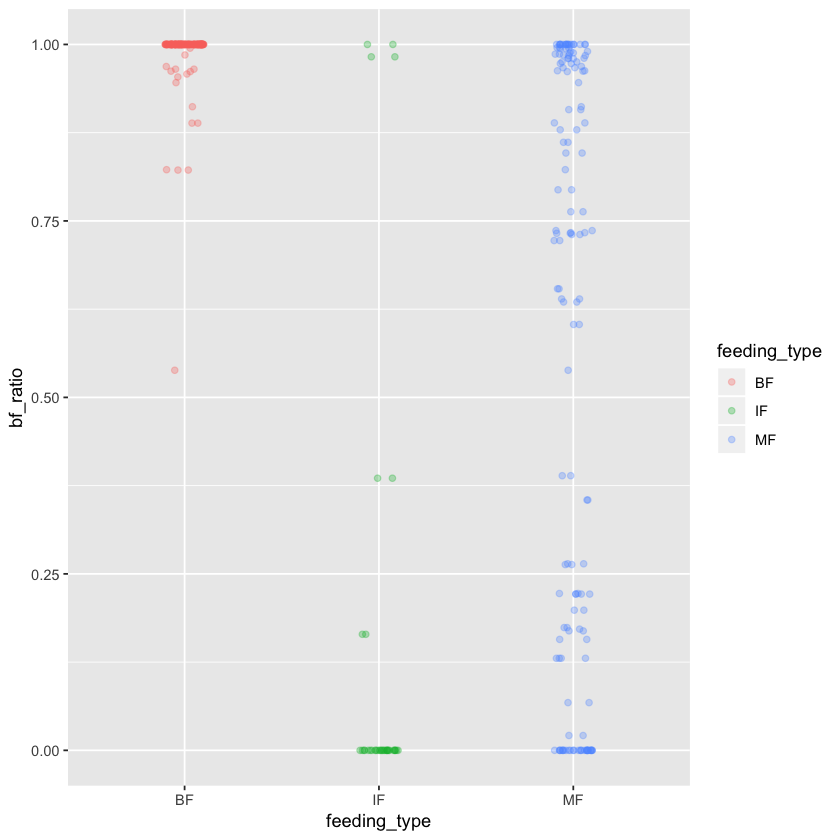

In [17]:
# finally I want to check how the bfratio is reflected in the
# food categories Gerben created. They should be similar despite
# some bf ratios that are not 1 or 0. But we see that some subjects should
# be in bf category but they ended in IF. Some of mixed
# should be either bf of if...
test <- read_csv(here("data/csv_gerben/data1.csv"))
test %>% select(subject, feeding_type) %>%
    rename(subject_id = subject) %>%
    left_join(data, by = "subject_id") %>%
    ggplot(aes(feeding_type, bf_ratio, color = feeding_type)) +
    geom_jitter(width = 0.1, alpha = 0.3)
ggsave("feeding_type_vs_bf_ratio.png")


# Model fitting




	Pearson's product-moment correlation

data:  data$bf_count and data$formula_count
t = -30.878, df = 184, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9361156 -0.8887431
sample estimates:
       cor 
-0.9155495 


Warning message:
“Removed 10 rows containing missing values (geom_point).”

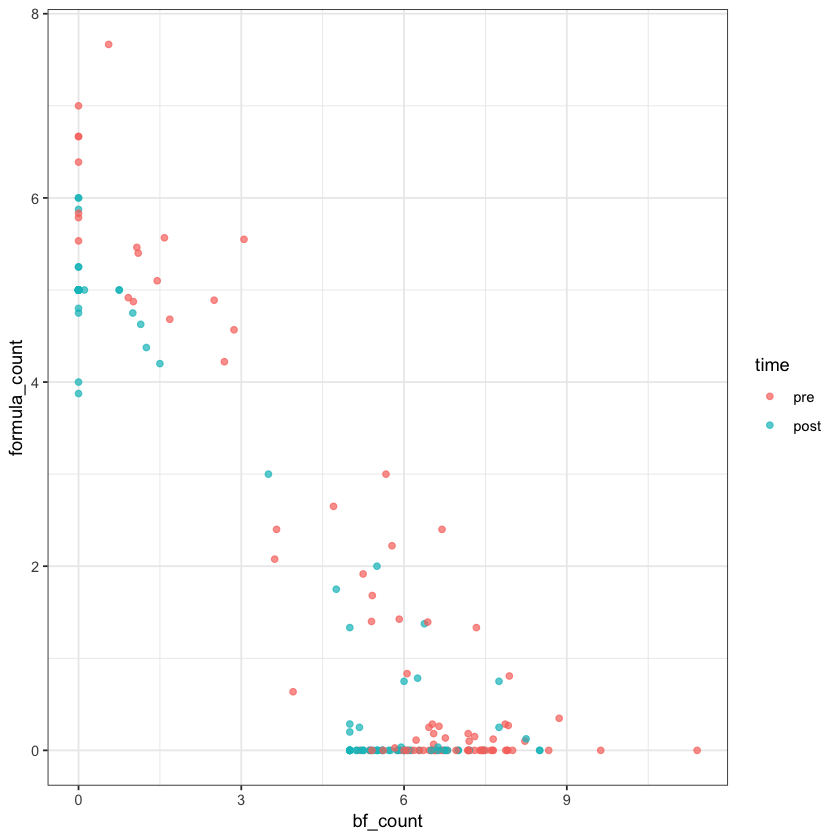

In [24]:
cor.test(data$bf_count, data$formula_count)
ggplot(data, aes(bf_count, formula_count, color = time)) +
    geom_point(alpha = 0.7) +
    theme_bw()

In [18]:
library(brms)
library(broom)
library(glue)
options(mc.cores = 4)
colnames(data) <- gsub(" ", "_", colnames(data))
colnames(data) <- gsub("\\.", "", colnames(data))
colnames(data)[which(colnames(data) == "Clostridium_\\(sensu_stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(data)
# check default contrasts
contrasts(data$time)

Loading required package: Rcpp
Loading 'brms' package (version 2.6.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.

Attaching package: ‘brms’

The following object is masked from ‘package:affy’:

    mm

The following object is masked from ‘package:phyloseq’:

    nsamples


Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse



[1] "subject_id"                          
  [2] "time"                                
  [3] "cc"                                  
  [4] "age_pre_d"                           
  [5] "age_post_d"                          
  [6] "age_startcc_w"                       
  [7] "weeks_cc"                            
  [8] "sample"                              
  [9] "bf_count_pre"                        
 [10] "bf_count_post"                       
 [11] "bf_count_cc"                         
 [12] "formula_count_pre"                   
 [13] "formula_count_post"                  
 [14] "formula_count_cc"                    
 [15] "bf_ratio_pre"                        
 [16] "bf_ratio_cc"                         
 [17] "bf_ratio"                            
 [18] "bf_count"                            
 [19] "formula_count"                       
 [20] "age_d"                               
 [21] "Actinomycetaceae"                    
 [22] "Aerococcus"                          
 [23] "Aeromonas"                           
 [24] "Akkermansia"                         
 [25] "Alcaligenes_faecalis_et_rel"         
 [26] "Allistipes_et_rel"                   
 [27] "Anaerobiospirillum"                  
 [28] "Anaerofustis"                        
 [29] "Anaerostipes_caccae_et_rel"          
 [30] "Anaerotruncus_colihominis_et_rel"    
 [31] "Anaerovorax_odorimutans_et_rel"      
 [32] "Aneurinibacillus"                    
 [33] "Aquabacterium"                       
 [34] "Asteroleplasma_et_rel"               
 [35] "Atopobium"                           
 [36] "Bacillus"                            
 [37] "Bacteroides_fragilis_et_rel"         
 [38] "Bacteroides_intestinalis_et_rel"     
 [39] "Bacteroides_ovatus_et_rel"           
 [40] "Bacteroides_plebeius_et_rel"         
 [41] "Bacteroides_splachnicus_et_rel"      
 [42] "Bacteroides_stercoris_et_rel"        
 [43] "Bacteroides_uniformis_et_rel"        
 [44] "Bacteroides_vulgatus_et_rel"         
 [45] "Bifidobacterium"                     
 [46] "Bilophila_et_rel"                    
 [47] "Brachyspira"                         
 [48] "Bryantella_formatexigens_et_rel"     
 [49] "Bulleidia_moorei_et_rel"             
 [50] "Burkholderia"                        
 [51] "Butyrivibrio_crossotus_et_rel"       
 [52] "Campylobacter"                       
 [53] "Catenibacterium_mitsuokai_et_rel"    
 [54] "Clostridium_sensu_stricto"           
 [55] "Clostridium_cellulosi_et_rel"        
 [56] "Clostridium_colinum_et_rel"          
 [57] "Clostridium_difficile_et_rel"        
 [58] "Clostridium_felsineum_et_rel"        
 [59] "Clostridium_leptum_et_rel"           
 [60] "Clostridium_nexile_et_rel"           
 [61] "Clostridium_orbiscindens_et_rel"     
 [62] "Clostridium_ramosum_et_rel"          
 [63] "Clostridium_sphenoides_et_rel"       
 [64] "Clostridium_stercorarium_et_rel"     
 [65] "Clostridium_symbiosum_et_rel"        
 [66] "Clostridium_thermocellum_et_rel"     
 [67] "Collinsella"                         
 [68] "Coprobacillus_catenaformis_et_rel"   
 [69] "Coprococcus_eutactus_et_rel"         
 [70] "Corynebacterium"                     
 [71] "Desulfovibrio_et_rel"                
 [72] "Dialister"                           
 [73] "Dorea_formicigenerans_et_rel"        
 [74] "Eggerthella_lenta_et_rel"            
 [75] "Enterobacter_aerogenes_et_rel"       
 [76] "Enterococcus"                        
 [77] "Escherichia_coli_et_rel"             
 [78] "Eubacterium_biforme_et_rel"          
 [79] "Eubacterium_cylindroides_et_rel"     
 [80] "Eubacterium_hallii_et_rel"           
 [81] "Eubacterium_limosum_et_rel"          
 [82] "Eubacterium_rectale_et_rel"          
 [83] "Eubacterium_siraeum_et_rel"          
 [84] "Eubacterium_ventriosum_et_rel"       
 [85] "Faecalibacterium_prausnitzii_et_rel" 
 [86] "Fusobacteria"                        
 [87] "Gemella"                             
 [88] "Granulicatella"                      
 [89] "Haemophilus"                       

,post
pre,0
post,1


In [19]:
# filter the correct samples and then add alpha diversities to final df
div <- div %>% filter(sample %in% data$sample)
data <- data %>%
    left_join(div, by = "sample")

In [20]:
data %>% head()

subject_id,time,cc,age_pre_d,age_post_d,age_startcc_w,weeks_cc,sample,bf_count_pre,bf_count_post,⋯,Xanthomonadaceae,Yersinia_et_rel,bf_count_s,formula_count_s,age_d_s,inverse_simpson,gini_simpson,shannon,fisher,coverage
207,post,no,68,98.00,10.00,4.571429,sa_10000,78.00,102.00,⋯,7.893030,8.144905,0.43948544,-0.7284908,0.0320946,5.355989,0.8132931,2.7056184,5.383346,2
388,post,yes,68,98.00,10.00,4.571429,sa_10038,51.00,51.00,⋯,7.866475,8.142760,-1.65710371,1.5479419,0.0320946,4.320260,0.7685325,2.2511439,5.316333,2
381,post,yes,78,108.00,11.43,4.571429,sa_10118,82.28,108.64,⋯,7.907949,8.152553,0.64565004,-0.7284908,0.5275689,1.928580,0.4814839,1.3443534,5.102534,1
283,post,yes,78,107.03,11.43,4.432857,sa_10211,75.00,95.00,⋯,7.893011,8.145466,0.09005391,-0.7284908,0.4795079,3.168516,0.6843948,2.1517162,5.370872,1
216,post,no,68,100.00,10.00,4.857143,sa_10230,71.29,99.29,⋯,7.913586,8.153854,0.78891696,-0.7284908,0.1311895,1.487507,0.3277344,1.1472825,5.231247,1
277,pre,yes,79,109.00,11.57,4.571429,sa_10247,61.00,91.00,⋯,8.143367,8.311815,0.47442859,-0.7284908,-0.9093066,1.330251,0.2482624,0.9327145,5.140466,1


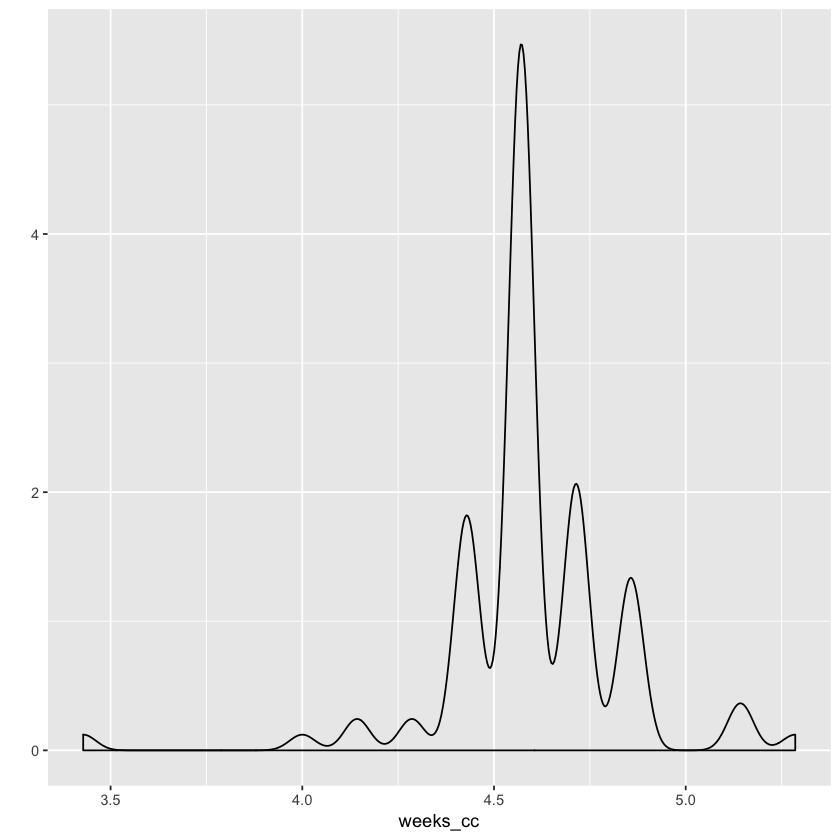

In [21]:
# How much variation in how long they went to cc is there?
qplot(weeks_cc, data = data, geom = "density")


## G vs T vs SN and relax sigma or not?

At first, I want to get some insight in which models are appropriate. Only if I find an appropriate model will I look at the actual coeffients of the models. I want to compare hierarchical generalized linear models of different families but also whether relaxing the assumption of constant variance improves the predictions of the model (I assume that if it does not, then should better stay away until I better understand why not). For the latter type of models, the linear equation predicts both, a location parameter $\mu$ and a scale parameter $\sigma$.

I hope I can later automate more but first I need to get a feeling for how these models behave. So for some genus, I will fit 3 families, and also both distributional ($\sigma$ is not constant) and the "regular" GLMs.

## Bilophila et rel
This genus has a small range in our dataset and is skewed.



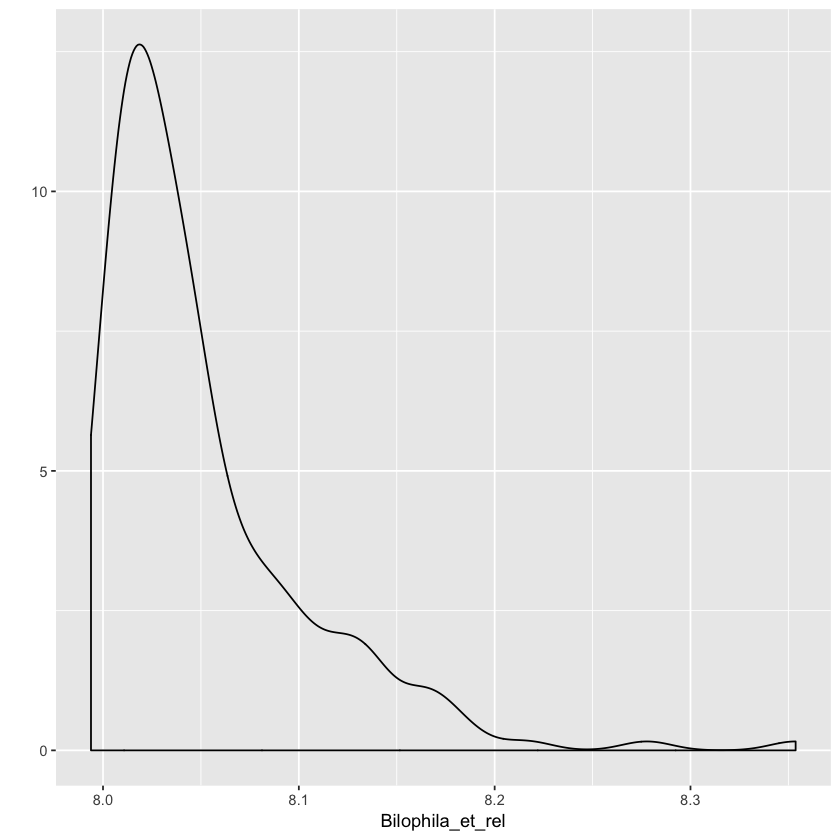

In [22]:
qplot(data = data, Bilophila_et_rel, geom = "density")

In [23]:
# set model options for distributional models
genus <-"Bilophila_et_rel"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))

folder_d <- here("models/cc_and_feeding/distributional/")
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
chains <- 4
iter <- 3000
warmup <- 1000
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
)

# define fitting functions for distributional models
brmd_g <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/gaussian/{genus}_time_cc")
    #fit model
    brm(
        family = gaussian(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_t <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/t/{genus}_time_cc")
    #fit model
    brm(
        family = student(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_sn <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/skew_normal/{genus}_time_cc")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

# set model options for constant sigma models
genus <-"Bilophila_et_rel"
f <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula <- bf(f)

folder <- here("models/cc_and_feeding/constant/")
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(10)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)



# define fitting functions for constant models
brm_g <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/gaussian/{genus}_time_cc")
    #fit model
    brm(
        family = gaussian(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_t <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/t/{genus}_time_cc")
    #fit model
    brm(
        family = student(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_sn <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_time_cc")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

In [24]:
cc_time_dg <- brmd_g()

Compiling the C++ model


In file included from file35f6708bb838.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core.hpp:14:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core/matrix_vari.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat/fun/Eigen_NumTraits.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/prim/mat/fun/Eigen.hpp

Start sampling
Warning message in gzfile(file, mode):
“cannot open compressed file '/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/cc_and_feeding/distributional//gaussian/Bilophila_et_rel_time_cc.rds', probable reason 'No such file or directory'”

ERROR: Error in gzfile(file, mode): cannot open the connection


In [ ]:
cc_time_dt <- brmd_t()

In [ ]:
cc_time_dsn <- brmd_sn()


**Thoughts:**
- I need to put a quite strong prior on the sd parameter, especially for the  t an gaussian models. Thus, the model is very sceptical of high variation there.
- I would only know how to automate if I put strong priors also on the others models that would also fit without warning with less regularizing priors. I could try to see if the estimates differ for skew normal if I put stronger priors there as well (edit: the estimates were not impacted)



In [ ]:
source(here("R/bayesian_helper.R"))
# We can check visually how well the model predicts outcomes
# using the same predictors as in our training data.
model_list <- list(cc_time_dg, cc_time_dt, cc_time_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })


According to the pp_checks, the skew_normal family can reproduce the data very nicely. I understand it like this: All models have to increase sigma to capture the outliers to the right compared to outcome distribution that was closer to a gaussian distribution. But for the symmetric models, this leads to outliers to the left as well, which we do not see in our real data. If there was a linear combitation of predictors that could be able to explain mean and variance of those outliers that problem would disappear. The student t model did not converge without a warning with the prior I tested. Therefore; I will ignore the coefficients for that model. Before I will interpret this model, I want model another genus that has a higher range in the distribution.



In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

In [ ]:
cc_time_g <- brm_g()
cc_time_t <- brm_t()
cc_time_sn <- brm_sn()

In [ ]:
model_list <- list(cc_time_g, cc_time_t, cc_time_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [ ]:
# take a closer look at the ppchecks of the best models constant sigma
# vs modelled sigma. I found that it can be helpful to inspect both violin
# and the density plots...
inspect_c2[[3]]
inspect_d2[[3]]

In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

The constant sigma model does not appear to be any worse if I only look at the predictive check. I miss other criteria to decide, which one then should be preferred for inference.


## Enterococcus
Again the distribution is skewed. If our predictors do not explain distribution, we get similar issues as with Bilophila.



In [ ]:
qplot(data = data, Enterococcus, geom = "density")

In [ ]:
# set model options distributional
genus <- "Enterococcus"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))
prior_d <- c(
            set_prior("normal(0, 1)", class = "b"),
            set_prior("exponential(15)", class = "sd"),
            set_prior("normal(0, 5)", class = "Intercept"),
            set_prior("normal(0, 1)", class = "b", dpar = "sigma"),
            set_prior("exponential(15)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma")
)

# set model options constant
f <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula <- bf(f)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)

In [ ]:
cc_time_dg <- brmd_g()

In [ ]:
cc_time_dt <- brmd_t()

In [ ]:
cc_time_dsn <- brmd_sn()


As wen can see: Even starting with weaker priors, we can fit all models.



In [ ]:
# We can check visually how well the model predicts outcomes
# using the same predictors as in our training data.
model_list <- list(cc_time_dg, cc_time_dt, cc_time_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })


Again, the skew normal seems most appropriate because it avoids predicting as many outliers to the left whereas all models predict outliers to the right. The coefficients indicate that the predictors can explain some of the distribution of Enterococcus although the effects appear to be smallest in the model that best could reproduce the data. I am not really happy with any of the models because of the outliers to the right. After showing the coefficients below I will fit one more genus before I start adding bf_ratio as a predictor...



In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

In [ ]:
cc_time_g <- brm_g()
cc_time_t <- brm_t()
cc_time_sn <- brm_sn()

In [ ]:
model_list <- list(cc_time_g, cc_time_t, cc_time_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [ ]:
inspect_c[[3]]
inspect_d[[3]] + facet_wrap(~)

In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

## Example contrasts

Since the contrast setting here is *contr.treatment* and the reference groups are pre (time) and noCC (cc), we can answer the question about whether the groups differ from each other as in the next cell. In the plots I compare the $\mu$ against the mean of *Enterococcus* abundance in all samples. This might be misleading however given the skew of the raw data. However, the differences should be informative instead. There, the dashed line represents 0.

In [ ]:
mus_and_sigmas <- 
    cc_time_dsn %>% 
        as.tibble() %>% 
        mutate(
            mu_nocc_pre = b_Intercept,
            mu_nocc_post = b_Intercept + b_timepost,
            mu_cc_pre = b_Intercept + b_ccyes,
            mu_cc_post = b_Intercept + b_ccyes + b_timepost.ccyes,
            sigma_nocc_pre = exp(b_sigma_Intercept),
            sigma_nocc_post = exp(b_sigma_Intercept + b_sigma_timepost),
            sigma_cc_pre = exp(b_sigma_Intercept + b_sigma_ccyes),
            sigma_cc_post = exp(b_sigma_Intercept + b_sigma_ccyes + b_sigma_timepost.ccyes),
        ) %>% select(c(209:216))


mus_and_sigmas %>% select(contains("mu")) %>% gather(estimate, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    geom_vline(xintercept = mean(data$Enterococcus), linetype = "dashed") +
    facet_wrap(~estimate)
                          
mus_and_sigmas %>% select(contains("sigma")) %>% gather(estimate, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    geom_vline(xintercept = sd(data$Enterococcus), linetype = "dashed") +
    facet_wrap(~estimate)


diffs <- 
    mus_and_sigmas %>% 
        mutate(mu_cc_vs_nocc_pre = mu_nocc_pre - mu_cc_pre,
               mu_cc_post_vs_nocc_post = mu_nocc_post - mu_cc_post,
               mu_cc_pre_vs_cc_post = mu_cc_pre - mu_cc_post,
               mu_nocc_pre_vs_nocc_post = mu_nocc_pre - mu_nocc_post,
               sigma_cc_vs_nocc_pre = (sigma_nocc_pre - sigma_cc_pre),
               sigma_cc_post_vs_nocc_post = (sigma_nocc_post - sigma_cc_post),
               sigma_cc_pre_vs_cc_post = (sigma_cc_pre - sigma_cc_post),
               sigma_nocc_pre_vs_nocc_post = (sigma_nocc_pre - sigma_nocc_post)
              ) %>% select(c(9:16))  

diffs %>%
    gather(comparison, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    geom_vline(xintercept = 0, linetype = "dashed") +
    facet_wrap(~comparison)

In [ ]:
diffs %>% 
    gather(comparison, value) %>%
    group_by(comparison) %>%
    do(data.frame(
        mean = mean(.$value),
        lower = hpdi(.$value, prob = 0.95)[1],
        upper = hpdi(.$value, prob = 0.95)[2]
    ))
    


## Bifidobacterium
This is the most abundant genus in the dataset as expected. Previous models I saw showed that predictors did not explain anything. I don't expect something else now but still want to try to fit a more appropriate model than before. With predictors that can explain this, it will be difficult to models with the tools I have.



In [ ]:
log10(7)

In [ ]:
qplot(data = data, Bifidobacterium, geom = "density")

In [ ]:
# set model options distributional
genus <- "Bifidobacterium"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))
prior_d <- c(
            set_prior("normal(0, 3)", class = "b"),
            set_prior("exponential(35)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 3)", class = "b", dpar = "sigma"),
            set_prior("exponential(40)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
)

# set model options constant
f <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula <- bf(f)
prior <- c(
            set_prior("normal(0, 3)", class = "b"),
            set_prior("exponential(35)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)

In [ ]:
cc_time_dg <- brmd_g()

In [ ]:
cc_time_dt <- brmd_t()

In [ ]:
cc_time_dsn <- brmd_sn()

In [ ]:
source(here("R/bayesian_helper.R"))
# We can check visually how well the model predicts outcomes
# using the same predictors as in our training data.
model_list <- list(cc_time_dg, cc_time_dt, cc_time_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })


As expected, the models are all crap as far as I can tell. They predict to high and too low abundance  and the reason will be that the predictors cannot explain the bimodal distribution. The student t model converged easiest but look at the extreme outlier it can produce (you need to set upper and lower at 6 to see it. Maybe the non-distrubtional model (with fixed sigma) will even do a better job here?! I want to test this once...If there is a setting how to make the skew normal model work I would consider it ok but the predictors are just no explaining enought of the bimodal distribution...



In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

In [ ]:
cc_time_g <- brm_g()
cc_time_t <- brm_t()
cc_time_sn <- brm_sn()

In [ ]:
model_list <- list(cc_time_g, cc_time_t, cc_time_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [ ]:
inspect_c2[[3]]
inspect_d2[[3]]

In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })


Indeed the skew normal with fixed sigma here would produce better model fit statistics I guess. Although it completely misses the second peak, it produces not as extreme outliers what about magnitude leading to smaler model accuracy statistics I guess. The other models further above would produce to many outliers to be better. The outliers must (?!) arise from overestimated error variance in the distributional models. Right now I would pick the simpler model. But lets add bf_ratio and hope that it explains maybe a litte of that bimodal distribution...



In [ ]:
# set model options distributional
genus <- "Bifidobacterium"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc*bf_ratio + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc*bf_ratio + (1|subject_id))
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

# set model options constant
f <- as.formula(glue("{genus} ~ 1 + time*cc*bf_ratio + (1|subject_id)"))
formula <- bf(f)


# redefine fitting functions for imputed datasets distributional
brmd_g_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/gaussian/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = gaussian(), data = data_imp, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_t_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/t/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = student(), data = data_imp, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_sn_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/skew_normal/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = skew_normal(), data = data_imp, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}


# redefine fitting functions for imputed datasets constant
brm_g_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/gaussian/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = gaussian(), data = data_imp, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_t_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/t/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = student(), data = data_imp, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_sn_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = skew_normal(), data = data_imp, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

In [ ]:
# impute data (I will need to check the right way later)
library(mice)
data_imp <-  data %>%
    select(-everything(), subject_id, time, cc, bf_count, Enterococcus, Staphylococcus) %>%
    mice(m = 10, print = F)
complete(data_imp)

In [ ]:
cc_time_bf_dg <- brmd_g_imp()

In [ ]:
cc_time_bf_dt <- brmd_t_imp()

In [ ]:
cc_time_bf_dsn <- brmd_sn_imp()

In [ ]:
source(here("R/bayesian_helper.R"))
model_list <- list(cc_time_bf_dg, cc_time_bf_dt, cc_time_bf_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })


Having seen the example for Bifidobacterium, obviously the question arises if the simpler models maybe do a better job for the other genus as well where see similar issues with regard to outliers. On the one hand, I might now try to overfit the training data if I say I want to avoid those completely but on the other hand the distributions really look as if an outlier to one side is extremely unlikely and therefore I would want the model not reflect this as well.



In [ ]:
cc_time_bf_g <- brm_g_imp()

In [ ]:
cc_time_bf_t <- brm_t_imp()

In [ ]:
cc_time_bf_sn <- brm_sn_imp()

In [ ]:
model_list <- list(cc_time_bf_g, cc_time_bf_t, cc_time_bf_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [ ]:
inspect_c2[[3]]
inspect_d2[[3]]

In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

In [ ]:
qplot(data = data, Staphylococcus, geom = "density")

In [ ]:
# set model options distributional
genus <- "Staphylococcus"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))
prior_d <- c(
            set_prior("normal(0, 3)", class = "b"),
            set_prior("exponential(70)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 3)", class = "b", dpar = "sigma"),
            set_prior("exponential(60)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
)

# set model options constant
f <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula <- bf(f)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(70)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)

In [ ]:
cc_time_dg <- brmd_g()

In [ ]:
cc_time_dt <- brmd_t()

In [ ]:
cc_time_dsn <- brmd_sn()

In [ ]:
model_list <- list(cc_time_dg, cc_time_dt, cc_time_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

In [ ]:
cc_time_g <- brm_g()
cc_time_t <- brm_t()
cc_time_sn <- brm_sn()

In [ ]:
model_list <- list(cc_time_g, cc_time_t, cc_time_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [ ]:
inspect_c2[[3]]
inspect_d2[[3]]

In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

In [ ]:
# set model options distributional
genus <- "Staphylococcus"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc*bf_ratio + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(70)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(50)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
)

# set model options constant
f <- as.formula(glue("{genus} ~ 1 + time*cc*bf_ratio + (1|subject_id)"))
formula <- bf(f)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(70)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)

In [ ]:
# impute data (I will need to check the right way later)
library(mice)
data_imp <-  data %>%
    select(-everything(), subject_id, time, cc, bf_ratio, genus) %>%
    mice(m = 5, print = F)

In [ ]:
cc_time_bf_dg <- brmd_g_imp()
cc_time_bf_dt <- brmd_t_imp()
cc_time_bf_dsn <- brmd_sn_imp()

In [ ]:
source(here("R/bayesian_helper.R"))
model_list <- list(cc_time_bf_dg, cc_time_bf_dt, cc_time_bf_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:14,]
    })

In [ ]:
cc_time_bf_g <- brm_g_imp()
cc_time_bf_t <- brm_t_imp()
cc_time_bf_sn <- brm_sn_imp()

In [ ]:
model_list <- list(cc_time_bf_g, cc_time_bf_t, cc_time_bf_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [ ]:
inspect_c2[[3]]
inspect_d2[[3]]

In [ ]:
lapply(model_list, function(model){
    broom::tidy(model)[1:14,]
    })

In [ ]:
# set model options for distributional models
genus <-"Bilophila_et_rel"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))

folder_d <- here("models/cc_and_feeding/distributional/")
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
chains <- 4
iter <- 3000
warmup <- 1000
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
)

# define fitting functions for distributional models
brmd_g <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/gaussian/{genus}_time_cc")
    #fit model
    brm(
        family = gaussian(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_t <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/t/{genus}_time_cc")
    #fit model
    brm(
        family = student(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_sn <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/skew_normal/{genus}_time_cc")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

# set model options for constant sigma models
genus <-"Bilophila_et_rel"
f <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula <- bf(f)

folder <- here("models/cc_and_feeding/constant/")
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(10)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)



# define fitting functions for constant models
brm_g <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/gaussian/{genus}_time_cc")
    #fit model
    brm(
        family = gaussian(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_t <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/t/{genus}_time_cc")
    #fit model
    brm(
        family = student(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_sn <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_time_cc")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

## Check distribution of bf_count to think about MI method

In [ ]:
ggplot(data, aes(Staphylococcus, bf_count)) +
    geom_point() +
    geom_smooth()

ggplot(data, aes(Enterococcus, bf_count)) +
    geom_point() +
    geom_smooth()

ggplot(data, aes(bf_ratio)) +
    geom_density()

ggplot(data, aes(bf_count)) +
    geom_density()


In [ ]:
ggplot(data, aes(bf_ratio, bf_count, label = subject_id, color = time)) +
    geom_text()

ggplot(data, aes(bf_ratio, formula_count, label = subject_id, color = time)) +
    geom_text()


## Compare time versus age variables

The information in time (pre/post) is implied in the age variable since for the second samples infants are always older and have had CC (the cc group). Age is a variable we should control for but time (pre/post) and age might mask each other in regression and therefore I think about just using age and then evaluate the interaction with CC. But look at the plot. In the no CC group age is nicely separated. Thus if we compare cc vs no cc, we compare at the same different age at baseline and post treatment. Therefore, I think I need to model the interaction $time \times cc$ and control for age to find out if time and CC explain any additional variance once we know age. But first I will compare age between and within groups to quantify this.

In [ ]:
ggplot(data, aes(time, age_d, color = time, label = subject_id)) +
    geom_violin() +
    geom_jitter(width = 0.2) +
    facet_wrap(~cc) +
    coord_flip()

In [ ]:
age_all <- brm(bf(age_d ~ time*cc, sigma ~ time*cc), data = data, file = here("models/age_bt_wn"))
age_cc <- brm(bf(age_d ~ cc, sigma ~ cc), data = data, file = here("models/age_bt"))

In [ ]:
ages_all <-
    age_all %>% 
        as.tibble() %>%
        mutate(
            pre_nocc_mu = b_Intercept,
            pre_cc_mu = b_Intercept + b_ccyes,
            post_nocc_mu = b_Intercept + b_timepost,
            post_cc_mu = b_Intercept + b_timepost + b_ccyes + b_timepost.ccyes, 
            pre_nocc_sigma = b_sigma_Intercept,
            pre_cc_sigma = b_sigma_Intercept + b_sigma_ccyes,
            post_nocc_sigma = b_sigma_Intercept + b_sigma_timepost,
            post_cc_sigma = b_sigma_Intercept + b_sigma_timepost + b_sigma_ccyes + b_sigma_timepost.ccyes) %>%
        select(pre_nocc_mu, pre_cc_mu, post_nocc_mu, post_cc_mu, pre_nocc_sigma, pre_cc_sigma, post_nocc_sigma, post_cc_sigma)
# prob that cc and no cc come from population with different mean age
# sounds kind of stupid since we know their age but the point is to 
# quantify if the difference is so large that it is picked up by the model 
# as such 
data %>% group_by(cc) %>% summarise(mean = mean(age_d), sd = sd(age_d))
data %>% group_by(cc, time) %>% summarise(mean = mean(age_d), sd = sd(age_d))
mean((ages_all$pre_cc_mu - ages_all$pre_nocc_mu) > 0)
# post should be the same but since samples were not given at same time points
# it could in theory differ
mean((ages_all$post_cc_mu - ages_all$post_nocc_mu) > 0)
# average time between groups per time point
mean(ages_all$post_cc_mu - ages_all$post_nocc_mu)
mean(ages_all$pre_cc_mu - ages_all$pre_nocc_mu)
# average time between samples per group
mean(ages_all$post_cc_mu - ages_all$pre_cc_mu)
mean(ages_all$post_nocc_mu - ages_all$pre_nocc_mu)

# plot difference mu
ages_all %>% select(pre_nocc_mu, pre_cc_mu) %>% 
    gather(group, age) %>%
    ggplot(aes(group, age)) +
        geom_violin() +
        geom_jitter(alpha = 0.05) +
        ggtitle("mu pre between CC") +
        coord_flip()

# plot difference sigma
ages_all %>% select(pre_nocc_sigma, pre_cc_sigma) %>% 
    gather(group, age) %>%
    ggplot(aes(group, age)) +
        geom_violin() +
        geom_jitter(alpha = 0.05) +
        ggtitle("sigma pre between CC") +
        coord_flip()

Thus, the ages are "significantly"  different between cc and no cc. Also, there clearly less variation in age in the no cc group. The mean difference is 11 days pre cc and 12 days post cc. The difference between samples is equivalent and is 30 days. However, more than 1 week difference in age might be confounding. I certainly will control for age.

In [ ]:
library(mice)
data_imp <-  data %>%
    select(-everything(), subject_id, age_d_s, time, cc, bf_count_s, Enterococcus, Staphylococcus) %>%
    mice(m = 5, print = F)

In [ ]:
library(brms)

In [ ]:
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(60)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))

control <- list(adapt_delta = 0.9999, max_treedepth = 15)

ent_time <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time*cc + (1+time|subject_id), sigma ~ 1 + time*cc + (1+time|subject_id)), 
        prior = prior_d, file = here("models/ent_time"),
        data = data)

ent_age <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + age_d_s*cc + (1+age_d_s|subject_id), sigma ~ 1 + age_d_s*cc + (1+age_d_s|subject_id)), 
        prior = prior_d, file = here("models/ent_age"),
        data = data)   

ent_time_age <-
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time*cc + age_d_s + (1+time + age_d_s|subject_id), sigma ~ 1 + time*cc + age_d_s + (1+time + age_d_s|subject_id)), 
        prior = prior_d, file = here("models/ent_time_age"),
        data = data) 

ent_complete <- 
    brm_multiple(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id), sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)), 
        prior = prior_d, file = here("models/ent_complete"), control = control,
        data = data_imp)

In [ ]:
broom::tidy(ent_time)[1:12,]
broom::tidy(ent_age)[1:12,]
broom::tidy(ent_time_age)[1:14,]
broom::tidy(ent_complete)[1:14,]

In [ ]:
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma"))

ent_time2 <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time + (1|subject_id), sigma ~ 1 + time + (1|subject_id)), 
        prior = prior_d,
        data = data)

ent_age2 <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + age_d_s + (1|subject_id), sigma ~ 1 + age_d_s + (1|subject_id)), 
        prior = prior_d,
        data = data)

In [ ]:
broom::tidy(ent_time2)[1:10,]
broom::tidy(ent_age2)[1:10,]

In [ ]:
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(30)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(30)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))

#ent_time3 <- 
 #   brm(
  #      family = skew_normal(), 
   #     bf(Enterococcus ~ 1 + time*cc + (1+time|subject_id), sigma ~ 1 + time*cc + (1+time|subject_id)), 
    #    prior = prior_d,
     #   data = data)

ent_age3 <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time*cc + age_d_s + (1 + time + age_d_s|subject_id), sigma ~ 1 + time*cc + age_d_s + (1 + time + age_d_s|subject_id)), 
        prior = prior_d,
        data = data) 

In [ ]:
broom::tidy(ent_time3)[1:10,]
broom::tidy(ent_age3)[1:10,]

In [ ]:
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(30)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(30)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))



ent_complete <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id), sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)), 
        prior = prior_d,
        data = data) 
broom::tidy(ent_age3)[1:10,]
broom::tidy(ent_complete)[1:10,]

In [ ]:
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(30)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(50)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 3)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))



bif_complete <- 
    brm(
        family = skew_normal(), 
        bf(Bifidobacterium ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id), sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)), 
        prior = prior_d,
        control = list(adapt_delta = 0.9999, max_treedepth = 15),
        data = data)

In [ ]:
source(here("R/bayesian_helper.R"))
broom::tidy(bif_complete)[1:14,]
bif_complete %>% 
    as.tibble() %>%
    gather(term, estimate) %>%
    group_by(term) %>%
    do(data.frame(
        mean = round(mean(.$estimate), 2),
        lower = round(hpdi(.$estimate)[1], 2),
        upper = round(hpdi(.$estimate)[2], 2)
    ))

In [ ]:
exp(-1.0396) # sigma cc no pre
exp(-1.0396 + 0.25301870) # sigma cc yes pre
exp(-1.0396 - 0.32468744) # sigma cc no post
exp(-1.0396 - 0.32468744 + 0.25301870 -0.68752035) # sigma cc yes post

In [ ]:
ggplot(data, aes(bf_count_s, age_d_s)) +
    geom_point() +
    geom_smooth()

cor.test(data$bf_count, data$age_d)

In [ ]:
dim(data)

In [ ]:
# select only genus that Gerben preselected, then save data
test <- read_csv(here("data/csv_gerben/data1.csv"))
selector <- colnames(test)

In [ ]:
selector <- selector[-c(1:2, 114:119)]

In [ ]:
colnames(data)
data_transfer <- 
    data %>% select(
        subject_id,
        sample,
        time, 
        cc, 
        age_d, 
        age_d_s, 
        bf_count, 
        bf_count_s,
        bf_ratio,
        selector) %>%
    rename(sample_id = sample)
save(data_transfer, file = here("data/data_transfer.RData"))

## Alpha diversity measures and CC
I first check one predictor after another for shannon index and then write the function for all indeces for the full model.

In [ ]:
# descrptives
data %>% group_by(cc, time) %>%
    summarise(mean_shannon = mean(shannon), sd_shannon = sd(shannon))
data %>% group_by(cc, time) %>%
    summarise(mean_inverse_simpson = mean(inverse_simpson), sd_inverse_simpson = sd(inverse_simpson))

# plot distributions
data %>% select(shannon, gini_simpson, inverse_simpson) %>%
    gather(index, value) %>%
ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~index, scales = "free")

In [ ]:
# ad_1 <- 
#     brm(
#         shannon ~ cc*time + (1 + time|subject_id), 
#         data = data, warmup = 1000, control = list(adapt_delta = 0.9999), prior = prior)
# tidy(ad_1)[1:12,]
# 
# ad_12 <- 
#     brm(
#         shannon ~ cc*time + age_d_s + (1 + time + age_d_s|subject_id), 
#         data = data, warmup = 1000, control = list(adapt_delta = 0.9999), prior = prior)
# tidy(ad_12)[1:12,]
# 
# ad_2 <- brm(shannon ~ age_d_s + (1 + age_d_s|subject_id), 
#         data = data, warmup = 1000, control = list(adapt_delta = 0.9999), prior = prior)
# tidy(ad_2)[1:12,]
# 
# ad_3 <- brm(shannon ~ bf_count_s + (1 + bf_count_s|subject_id), 
#         data = data, warmup = 1000, control = list(adapt_delta = 0.9999), prior = prior)
# tidy(ad_3)[1:12,]
# 
# # specify prior 
# prior_n <- c(
#             set_prior("normal(0, 2)", class = "b", resp = "shannon"),
#             set_prior("exponential(25)", class = "sd", resp = "shannon"),
#             set_prior("normal(0, 10)", class = "Intercept", resp = "shannon"), 
#             set_prior("lkj(2)", class = "cor"),             
#             set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
#             set_prior("exponential(25)", class = "sd", resp = "bfcounts"),
#             set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
# bform <- bf(shannon | mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)) +
#             bf(bf_count_s | mi() ~ age_d_s + cc*time + shannon + (1 +time +age_d_s + shannon|subject_id)) + set_rescor(FALSE)
# ad_4 <- 
#     brm(bform, 
#         data = data, warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), prior = prior_n)
# tidy(ad_4)[1:12,]
# 
# ad_5 <- 
#     brm(
#         shannon ~ cc*time*bf_count_s + age_d_s + (1 + time*bf_count_s + age_d_s|subject_id), 
#         data = data, warmup = 1000, control = list(adapt_delta = 0.9999), prior = prior_d)
# tidy(ad_5)[1:12,]

In [ ]:
# specify prior 
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("lkj(2)", class = "cor"))

# where to store models
folder <- here("models/")
diversity_index <- c("shannon", "inverse_simpson", "gini_simpson")

In [ ]:
brm_div <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/gaussian/{diversity_index}_full")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999), 
            prior = prior, file = model_file
        )
}

brm_div_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior 
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(25)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(25)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/gaussian/{diversity_index}_full_mi")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

brm_div_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/skew_normal/{diversity_index}_full")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999), 
            prior = prior, file = model_file
        )
}


brm_div_skew_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior 
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(25)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(25)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/skew_normal/{diversity_index}_full_mi")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}


In [ ]:
# gaussianfamily and listwise deletion
div_models <- 
    lapply(diversity_index, brm_div)
# gaussian and mi for bf_count_s missingness
div_models_mi <- 
    lapply(diversity_index, brm_div_mi)
# skew family and listwise deletion
div_models_skew <- 
    lapply(diversity_index, brm_div_skew)
# skew family and mi for bf_count_s missingness
div_models_skew_mi <- 
    lapply(diversity_index, brm_div_skew_mi)

In [ ]:
source(here("R/bayesian_helper.R"))
pp_div <- 
    lapply(1:length(div_models), function(x) {
       pp_plot(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_skew <-
    lapply(1:length(div_models_skew), function(x) {
       pp_plot(div_models_skew[[x]], 10,  diversity_index[x])

    } )
pp_div_skew_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew[[x]], 10,  diversity_index[x])
    } )
pp_div_mi <- 
    lapply(1:length(div_models_mi), function(x) {
       pp_plot(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi <-
    lapply(1:length(div_models_skew_mi), function(x) {
       pp_plot(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )

In [ ]:
pp_div_skew_mi_v2

In [ ]:
pp_div_mi_v2

In [ ]:
lapply(div_models_skew_mi, function(x) {
    tidy(x)[1:13,]
})

In [ ]:
lapply(div_models, function(x) {
    tidy(x)[1:12,]
})

In [ ]:
lapply(1:length(div_models), function(x) {
   print(pp_plot(div_models[[x]], 10,  diversity_index[x], lower = 0.8, upper = 0.8))
   pp_plot_v2(div_models[[x]], 10,  diversity_index[x], lower = 0.8, upper = 0.8)
} )

In [ ]:
lapply(1:length(div_models_skew), function(x) {
   print(pp_plot(div_models_skew[[x]], 10,  diversity_index[x], lower = 0.8, upper = 0.8))
   pp_plot_v2(div_models_skew[[x]], 10,  diversity_index[x], lower = 0.8, upper = 0.8)
} )

In [ ]:
lapply(div_models_skew, function(x) {
    tidy(x)[1:12,]
})

In [ ]:
source(here("R/bayesian_helper.R"))
p_samples <- posterior_samples(div_models_skew_mi[[2]])

# if we imputed data with brms, then output will be array and we first need
# to select the correct dim
if (length(dim(p_samples)) > 2) {
    p_samples <- p_samples[, , 1]
}
colnames(p_samples) <- gsub("shannon_", "", colnames(p_samples))
colnames(p_samples) <- gsub("ginisimpson_", "", colnames(p_samples))
colnames(p_samples) <- gsub("inversesimpson_", "", colnames(p_samples))
p_samples %>% head()

In [ ]:
source(here("R/bayesian_helper.R"))

contrast_plot <- function(model) {
    # compare post_cc to all other groups
    mean_diff <- 
        cc_time_contrast(model) %>%
            mutate(
                post_cc_min_post_nocc = post_cc_mu - post_nocc_mu,
                post_cc_min_pre_cc = post_cc_mu - pre_cc_mu,
                post_cc_min_pre_nocc = post_cc_mu - pre_nocc_mu
            ) %>%
            select(post_cc_min_post_nocc, post_cc_min_pre_cc, post_cc_min_pre_nocc)
    # what is the prob that post_cc is not different from group xyz
    mean_diff %>% summarise_all(function(x) mean(x>0)) %>% print()
    # plot posterior mean post_cc - other mean
    mean_diff %>%
        gather(term, value) %>%
        group_by(term) %>%
        do(data.frame(
            mean = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2]
        )) %>%
        ggplot(aes(term, mean)) +
            geom_pointrange(aes(ymin = lower, ymax = upper)) +
            geom_hline(aes(yintercept = 0), linetype = "dashed") +
            ylim(-1, 0.5) +
            coord_flip()}
                                
lapply(div_models_skew_mi, contrast_plot)
                                




# TODO
Before interpreting this, clear up the confusion about why these values that were stored in the sample data are so different from what I did...

In [ ]:
ivs1 <- sample_data(genus) %>% 
    select(sample, diversity.invsimpson) 
    
ivs2 <- data %>% 
    select(sample, inverse_simpson)
ivs3 <- diversities(genus, index = "all") %>% 
    rownames_to_column("sample") %>%
    select(sample, inverse_simpson)

left_join(ivs1, ivs2, by = "sample") %>% 
    left_join(ivs3, by = "sample") %>%
    na.omit() %>%
    mutate(
        invsimpson_s = scale(diversity.invsimpson)[, 1], 
        invsimpson_s1 = scale(inverse_simpson.x)[, 1],
        invsimpson_s2 = scale(inverse_simpson.y)[, 1]) %>%
        select(sample, invsimpson_s, invsimpson_s1, invsimpson_s2)


In [ ]:
dd2 <- 
    data %>% left_join(ivs1, by = "sample") %>%
        mutate(diversity_invsimpson = scale(diversity.invsimpson)[, 1])
    
brm_div_skew_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior 
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(25)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(25)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/skew_normal/{diversity_index}_full_mi")
        #fit model
        brm(
            family = skew_normal(), data = dd2, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

test <- brm_div_skew_mi("diversity_invsimpson")

In [ ]:
source(here("R/bayesian_helper.R"))
contrast_plot(test)

In [ ]:
10^(0.25)